# DSME Bonus Point Assignment I Part B
<div style="text-align: right;font-size: 0.8em">Document Version 1.0.2, released 2021-01-08</div>
For task instructions, refer to the assignment PDF.

* The parts of the code you are to implement are indicated via `# TODO` comments.
* You can use the `# Test code` cells to verify your implementation. However note that these are not the unit tests used for grading.
* Some cells create export file in the `solution/` folder. _Include whole `solution/` folder in your submission_.
* DO NOT CLEAR THE OUTPUT of the notebook you are submitting!

In [1]:
# General imports
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm

# Enable reproducibility
torch.manual_seed(0)
torch.set_deterministic(True)

# Create solution folder
Path("solution/").mkdir(exist_ok=True)

In case you are missing dependencies (e.g. `ModuleNotFoundError: No module named ...`), run
```sh
conda install -y pandas seaborn scikit-learn pytorch torchvision cpuonly -c pytorch
```
in a terminal.

## Question B1 - Data Preprocessing
### a) Dataset Loading

In [2]:
# TODO Read CSV file

df = pd.read_csv('energy-weather.cvs', sep = ',') #parse_dates = ["time"]
df.head()


,time,temperature,pressure,humidity,wind_speed,wind_deg,rain_1h,clouds_all,generation_solar
0,2015-01-01 00:00:00,270.475,1001,77,1,62,0.0,0,49.0
1,2015-01-01 01:00:00,270.475,1001,77,1,62,0.0,0,50.0
2,2015-01-01 02:00:00,269.686,1002,78,0,23,0.0,0,50.0
3,2015-01-01 03:00:00,269.686,1002,78,0,23,0.0,0,50.0
4,2015-01-01 04:00:00,269.686,1002,78,0,23,0.0,0,42.0


In [3]:
# Test code
assert 'df' in locals(), "Variable df is not defined"
np.testing.assert_array_equal(df.columns, ['time', 'temperature', 'pressure','humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'clouds_all', 'generation_solar'])
np.testing.assert_equal(len(df), 30046)
"ok"

'ok'

### b) Filtering

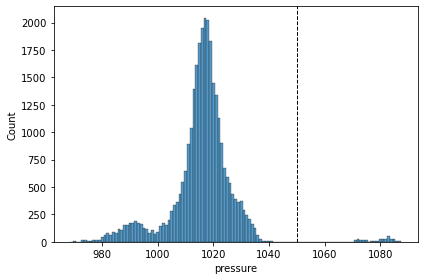

In [4]:
# Show histogram of pressure
sns.histplot(data=df["pressure"], discrete=True)
plt.axvline(1050, c="black", linestyle="dashed",linewidth=1)
plt.tight_layout()

In [5]:
# TODO Remove outliers from the data set

df_filtered = df.drop(df[(df.pressure > 1050) | (df.wind_speed >30)].index)


In [6]:
# Test code
assert 'df_filtered' in locals(), "Variable df_filtered is not defined"
assert (df_filtered["pressure"] <= 1050).all(), "contains pressure > 1050"
assert (df_filtered["wind_speed"] <= 30).all(), "contains wind_speed > 30"
assert len(df_filtered) == 29731, "Dropped too many rows"
"ok"

'ok'

### c) Additional features

In [7]:
# TODO Introduce day feature

df_filtered.loc[:, "day"] = pd.to_datetime(df_filtered["time"]).dt.dayofyear

# TODO Introduce generation_solar_categorical feature
df_filtered.loc[df_filtered["generation_solar"] < 160, "generation_solar_categorical"] = "low"

df_filtered.loc[(df_filtered["generation_solar"] >= 160) & (df_filtered["generation_solar"] <1600), "generation_solar_categorical"] = "medium"

df_filtered.loc[df_filtered["generation_solar"] >= 1600, "generation_solar_categorical"] = "high"

df_filtered["generation_solar_categorical"] = df_filtered["generation_solar_categorical"].astype('category')


In [8]:
# Test code
assert all(df_filtered.loc[df_filtered["time"] == "2015-03-02 21:00:00", "day"] == 61)
assert all(df_filtered.loc[df_filtered["time"] == "2018-08-06 11:00:00", "day"] == 218)

assert all(df_filtered["generation_solar_categorical"][df_filtered["generation_solar"] < 160] == "low"), "low label not correct"
assert all(df_filtered["generation_solar_categorical"][(160 <= df_filtered["generation_solar"]) & (df_filtered["generation_solar"] < 1600)] == "medium"), "medium label not correct"
assert all(df_filtered["generation_solar_categorical"][1600 <= df_filtered["generation_solar"]] == "high"), "high label not correct"
"ok"

'ok'

### d) Normalize Data

In [9]:
# TODO Standardize the dataset

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_filtered[["temperature","pressure","humidity","wind_speed","wind_deg","rain_1h","clouds_all","generation_solar","day"]] = scaler.fit_transform(df_filtered[["temperature","pressure","humidity","wind_speed","wind_deg","rain_1h","clouds_all","generation_solar","day"]]) 


In [10]:
# Test code
assert "time" in df_filtered.columns
assert "generation_solar_categorical" in df_filtered.columns

for f in ["temperature", "pressure", "humidity", "wind_speed", "wind_deg", "rain_1h", "clouds_all", "generation_solar", "day"]:
    assert np.isclose(np.mean(df_filtered[f]), 0), f"{f} is not standardized"
    assert np.isclose(np.std(df_filtered[f]), 1), f"{f} is not standardized"

"ok"

'ok'

### e) Train/Validation split

In [11]:
# TODO Train-validation split

from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df_filtered, test_size=0.1)


In [12]:
# Test code
assert len(df_train) == 26757, "df_train has wrong size"
assert len(df_val) == 2974, "df_test has wrong size"
assert not df_val.index.isin(df_train.index).any(), "df_test and df_train not disjunct"
assert not df_train.index.isin(df_val.index).any(), "df_test and df_train not disjunct"

# Export data sets
df_train.to_csv("solution/b1e-train.csv", index=False)
df_val.to_csv("solution/b1e-val.csv", index=False)

"ok"

'ok'

## Question B2 - Modelling with scikit-learn

### a) Linear regression

In [13]:
from sklearn.linear_model import LinearRegression

predictors = ["day", "temperature", "pressure", "humidity", "wind_speed", "wind_deg", "rain_1h", "clouds_all"]
target = "generation_solar"

# ********************
# TODO Fit linear model

model = LinearRegression().fit(df_train[predictors],df_train[target])


MSE linear: 0.6408018660239988


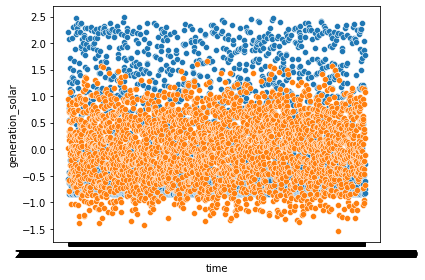

In [14]:
# Test Code
assert "model" in locals(), "Model not implemented"
assert model.coef_.shape == (8, ), "Wrong number of predictors"
_pred = model.predict(df_val[predictors])
sns.scatterplot(x=df_val["time"], y=df_val[target])
sns.scatterplot(x=df_val["time"], y=_pred)
plt.tight_layout()
plt.savefig("solution/b2a.png")
mse = np.mean((_pred - df_val[target])**2)
print(f"MSE linear: {mse}")

### b) Linear regression with non-linear basis functions

In [15]:
from sklearn.preprocessing import PolynomialFeatures

# TODO Create polynomial feature transformation

poly = PolynomialFeatures(degree=3) #above 4 it gives big MSEs
df_train_LR = poly.fit_transform(df_train[predictors])

# TODO Fit linear model

model_poly = LinearRegression().fit(df_train_LR,df_train[target])


MSE poly: 0.5448201112620173


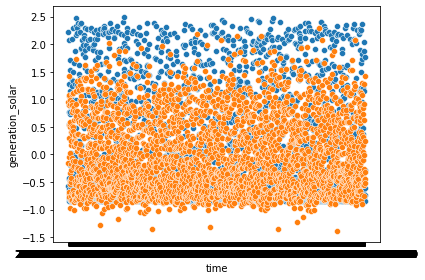

In [16]:
# Test Code
assert "model_poly" in locals(), "model_poly not implemented"
_pred = model_poly.predict(poly.transform(df_val[predictors]))
sns.scatterplot(x=df_val["time"], y=df_val[target])
sns.scatterplot(x=df_val["time"], y=_pred)
plt.tight_layout()
plt.savefig("solution/b2b.png")
mse = np.mean((_pred - df_val[target])**2)
print(f"MSE poly: {mse}")

### b) Classification

In [17]:
from sklearn.linear_model import RidgeClassifier

target = "generation_solar_categorical"

# TODO Fit classifier

model_cls = RidgeClassifier().fit(df_train[predictors],df_train[target])


In [18]:
# Test Code
assert "model_cls" in locals(), "model_cls not implemented"
from sklearn.metrics import classification_report
print(classification_report(df_val[target], model_cls.predict(df_val[predictors]), digits=4))

              precision    recall  f1-score   support

        high     0.6037    0.8137    0.6931      1009
         low     0.5756    0.7055    0.6339       988
      medium     0.5186    0.2139    0.3029       977

    accuracy                         0.5807      2974
   macro avg     0.5659    0.5777    0.5433      2974
weighted avg     0.5664    0.5807    0.5453      2974



## Question B3 - Modelling with PyTorch

In [19]:
# Build data loaders for PyTorch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

predictors = ["day", "temperature", "pressure", "humidity", "wind_speed", "wind_deg", "rain_1h", "clouds_all"]

x_train = torch.tensor(df_train[predictors].values,  dtype=torch.float)
x_val = torch.tensor(df_val[predictors].values,  dtype=torch.float)

y_train = torch.tensor(df_train[["generation_solar"]].values,  dtype=torch.float)
y_val = torch.tensor(df_val[["generation_solar"]].values,  dtype=torch.float)


y_train_cat = torch.tensor(df_train["generation_solar_categorical"].cat.codes.values.copy(),  dtype=torch.int64)
y_val_cat = torch.tensor(df_val["generation_solar_categorical"].cat.codes.values.copy(),  dtype=torch.int64)


# For regression
dataset = TensorDataset(x_train, y_train)

# For classification
dataset_cat = TensorDataset(x_train, y_train_cat)

### a) Build a network

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # TODO Create layers
        self.fc1 = nn.Linear(8,10)
        self.fc2 = nn.Linear(10,10)
        self.fc3 = nn.Linear(10,1)

    def forward(self, x):
        # TODO Implement forward pass
        import torch.nn.functional as F
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

net = Net()  # changed 2021-01-04: This variable is now called net

In [21]:
# Test code
np.testing.assert_array_equal([p.nelement() for p in net.parameters()], [80, 10, 100, 10, 10, 1])
np.testing.assert_array_equal(net(torch.zeros(32, 8)).shape, [32, 1])
"ok"

'ok'

### b) Regression

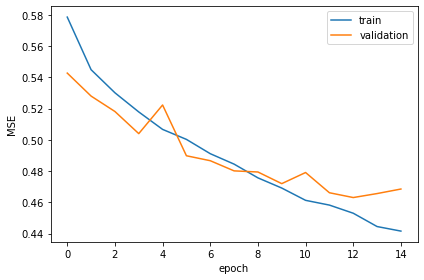

In [22]:
# TODO: Tune typerparameters 
# Hyperparameters
learn_rate = 0.0003 
epochs = 15 
batch_size = 15 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # TODO Create layers
        self.fc1 = nn.Linear(8,300) 
        self.fc2 = nn.Linear(300,350) 
        self.fc3 = nn.Linear(350,100) 
        self.fc4 = nn.Linear(100,1)

    def forward(self, x):
        # TODO Implement forward pass
        import torch.nn.functional as F
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = self.fc4(x)
        
        return x
net = Net()


criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learn_rate)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

losses = []
with tqdm(range(epochs)) as pbar:
    for epoch in pbar:  # loop over the dataset multiple times
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(dataloader):
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item() * inputs.shape[0]
        losses.append([running_loss / len(dataset), criterion(net(x_val), y_val).item()])
        pbar.set_description(f"MSE {losses[-1][0]:.02f}/{losses[-1][1]:.02f}")

# Save model
with open("solution/b3b.pt", "wb") as f:
    torch.save(net, f)

# Plot loss
losses = np.array(losses)
plt.plot(np.arange(len(losses)), losses[:,0], label="train")
plt.plot(np.arange(len(losses)), losses[:,1], label="validation")
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
plt.savefig("solution/b3b.png")

### c) Classification

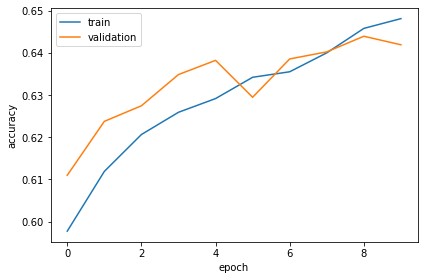

In [23]:
# TODO: Tune typerparameters 
# Hyperparameters
learn_rate = 0.0005
epochs = 10
batch_size = 10 #1-30046

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # TODO Create layers
        self.fc1 = nn.Linear(8,300)
        self.fc2 = nn.Linear(300,350)
        self.fc3 = nn.Linear(350,100)
        self.fc4 = nn.Linear(100,3)

    def forward(self, x):
        # TODO Implement forward pass
        import torch.nn.functional as F
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = self.fc4(x)
        
        return x
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learn_rate)
dataloader_cat = DataLoader(dataset_cat, batch_size=batch_size, shuffle=True)

losses=[]
with tqdm(range(epochs)) as pbar:
    for epoch in pbar:  # loop over the dataset multiple times
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(dataloader_cat):
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += torch.sum((torch.argmax(outputs, dim=1) == labels))  # changed 2021-01-08: Fixed accuracy computation
        losses.append([running_loss / len(dataset_cat), torch.sum((torch.argmax(net(x_val), dim=1) == y_val_cat)) / len(x_val)])  # changed 2021-01-08: Fixed accuracy computation
        pbar.set_description(f"Accuracy {losses[-1][0]:.02f}/{losses[-1][1]:.02f}")

# Save model
with open("solution/b3c.pt", "wb") as f:
    torch.save(net, f)

# Plot loss
losses = np.array(losses)
plt.plot(np.arange(len(losses)), losses[:,0], label="train")
plt.plot(np.arange(len(losses)), losses[:,1], label="validation")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.tight_layout()
plt.savefig("solution/b3c.png")

### d) Evaluation

Which model do you think is suited the best for modelling `generation_solar` and why? Please write down your answer below.

Selecting the correct algorithm for our machine learning problem is critical for understanding what results you need. Generation_solar is the result which maps the useful features like "temperature", "pressure", "humidity", "wind_speed", "wind_deg", "rain_1h" and "clouds_all" throughout the year. Here, we need to know how to differentiate between regression predictive models and classification predictive models so that you can choose the best one for our specific use case.

Regression and classification are both different approaches we can take to map these results. Regression maps an input X to y = f(X) which is a numerical value. Numerical value is not very much of the interest since during the year we might have similar seasonal conditions and these conditions are captured in the data "temperature", "pressure", "humidity", "wind_speed", "wind_deg", "rain_1h" and "clouds_all". Hence, it is better to categorize the generation_solar, thus classification is a better way to map the input features to the output "high", "medium" and "low". Also, during the year, we will be interested in whether we'll have a "high", "medium" and "low" level of generation_solar and not in the actual values. From this point of view, classification is our choice to model generation_solar.

On the contrary, it highly depends on what is the main purpose of the "generation_solar" output. If it is further clubbed with overall energy generation for those four years and find the percentage of energy generation through solar then the numerical values are very much of the interest. From this point of view, regression will be a best modelling approach. In hindsight, it is highly dependent on the relevance of data for further use. 